### load dataset :

In [1]:
import pandas as pd

train = pd.read_csv("/kaggle/input/playground-series-s5e10/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e10/test.csv")

train.shape, test.shape

((517754, 14), (172585, 13))

### Explore dataset

In [2]:
print(train.head())

   id road_type  num_lanes  curvature  speed_limit  lighting weather  \
0   0     urban          2       0.06           35  daylight   rainy   
1   1     urban          4       0.99           35  daylight   clear   
2   2     rural          4       0.63           70       dim   clear   
3   3   highway          4       0.07           35       dim   rainy   
4   4     rural          1       0.58           60  daylight   foggy   

   road_signs_present  public_road time_of_day  holiday  school_season  \
0               False         True   afternoon    False           True   
1                True        False     evening     True           True   
2               False         True     morning     True          False   
3                True         True     morning    False          False   
4               False        False     evening     True          False   

   num_reported_accidents  accident_risk  
0                       1           0.13  
1                       0           

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

### Check for missing values

In [4]:
train.isna().sum()  

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

## EDA :


### Bar plots of mean accident risk by categorical features


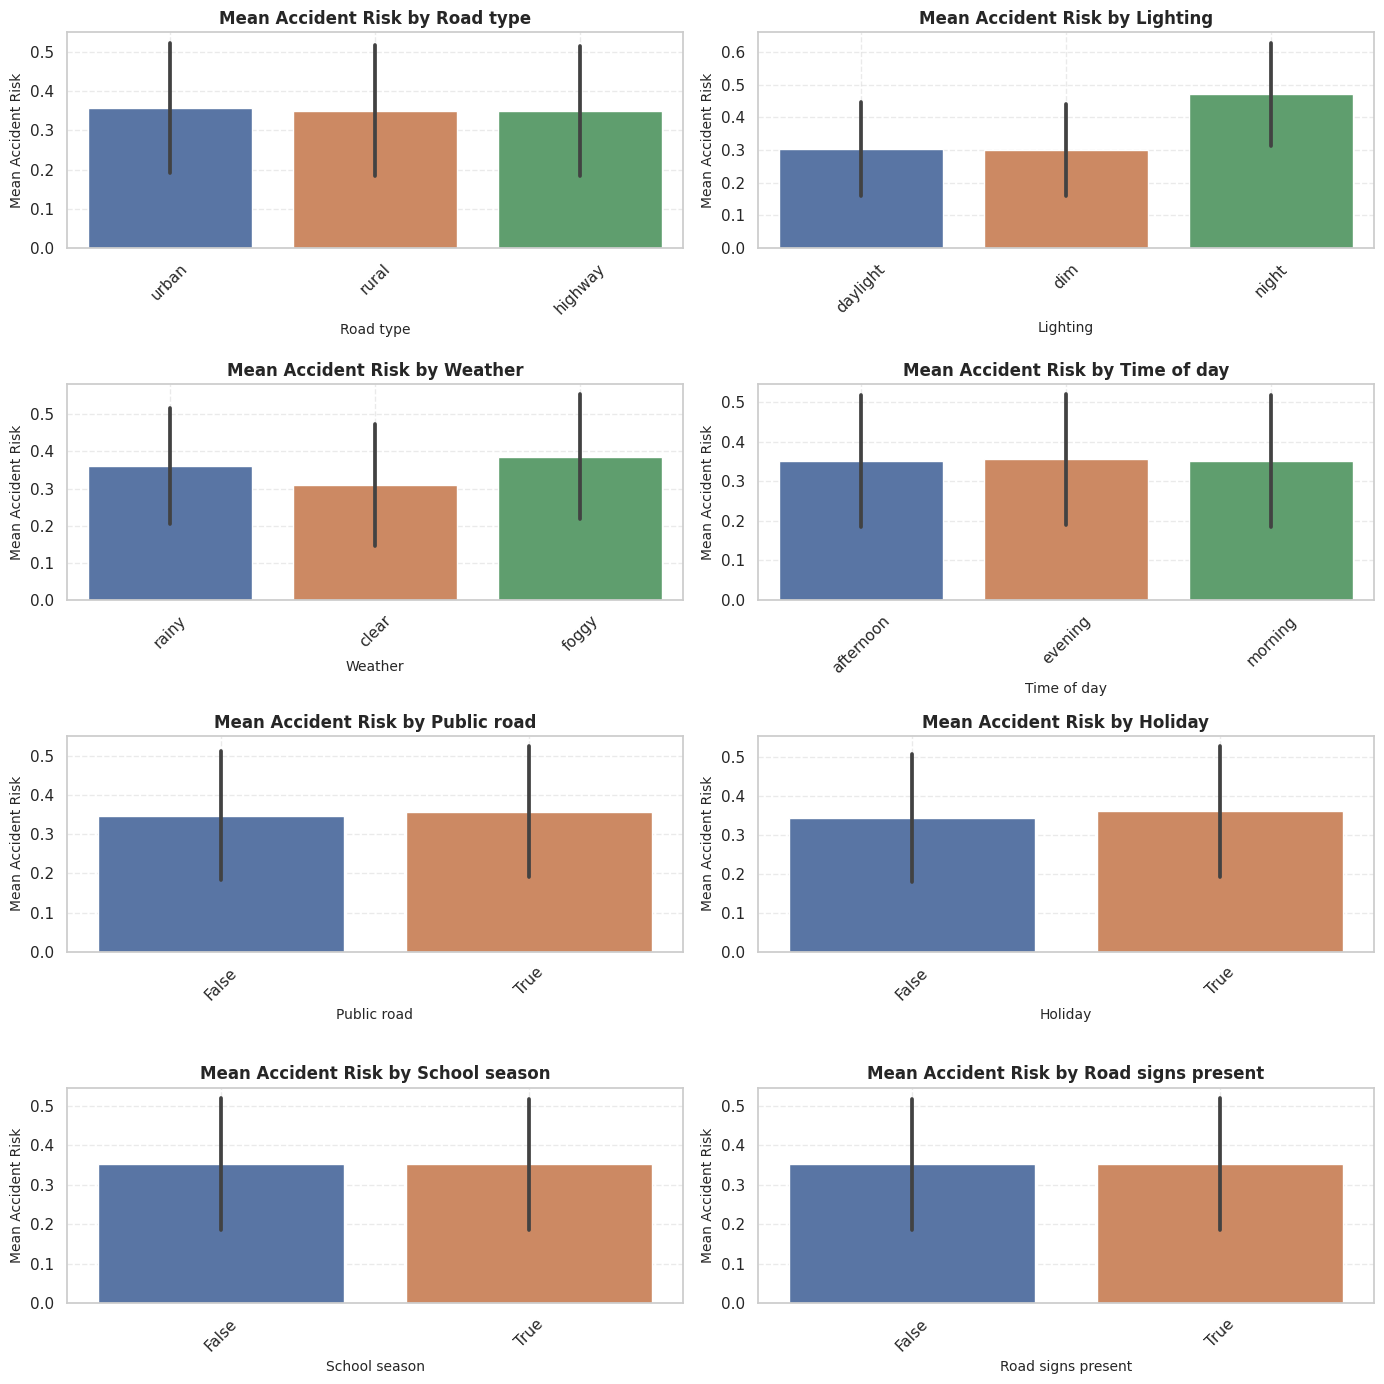

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

cat_features = [
    'road_type', 'lighting', 'weather', 'time_of_day',
    'public_road', 'holiday', 'school_season', 'road_signs_present'
]

fig, axes = plt.subplots(4, 2, figsize=(14, 14))
axes = axes.flatten()

for i, col in enumerate(cat_features):
    sns.barplot(
        x=col,
        y='accident_risk',
        data=train,
        estimator='mean',
        errorbar='sd',
        ax=axes[i]
    )
    axes[i].set_title(f"Mean Accident Risk by {col.replace('_', ' ').capitalize()}", fontsize=12, weight='bold')
    axes[i].set_xlabel(col.replace('_', ' ').capitalize(), fontsize=10)
    axes[i].set_ylabel("Mean Accident Risk", fontsize=10)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### Histograms of numerical feature distributions


In [6]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

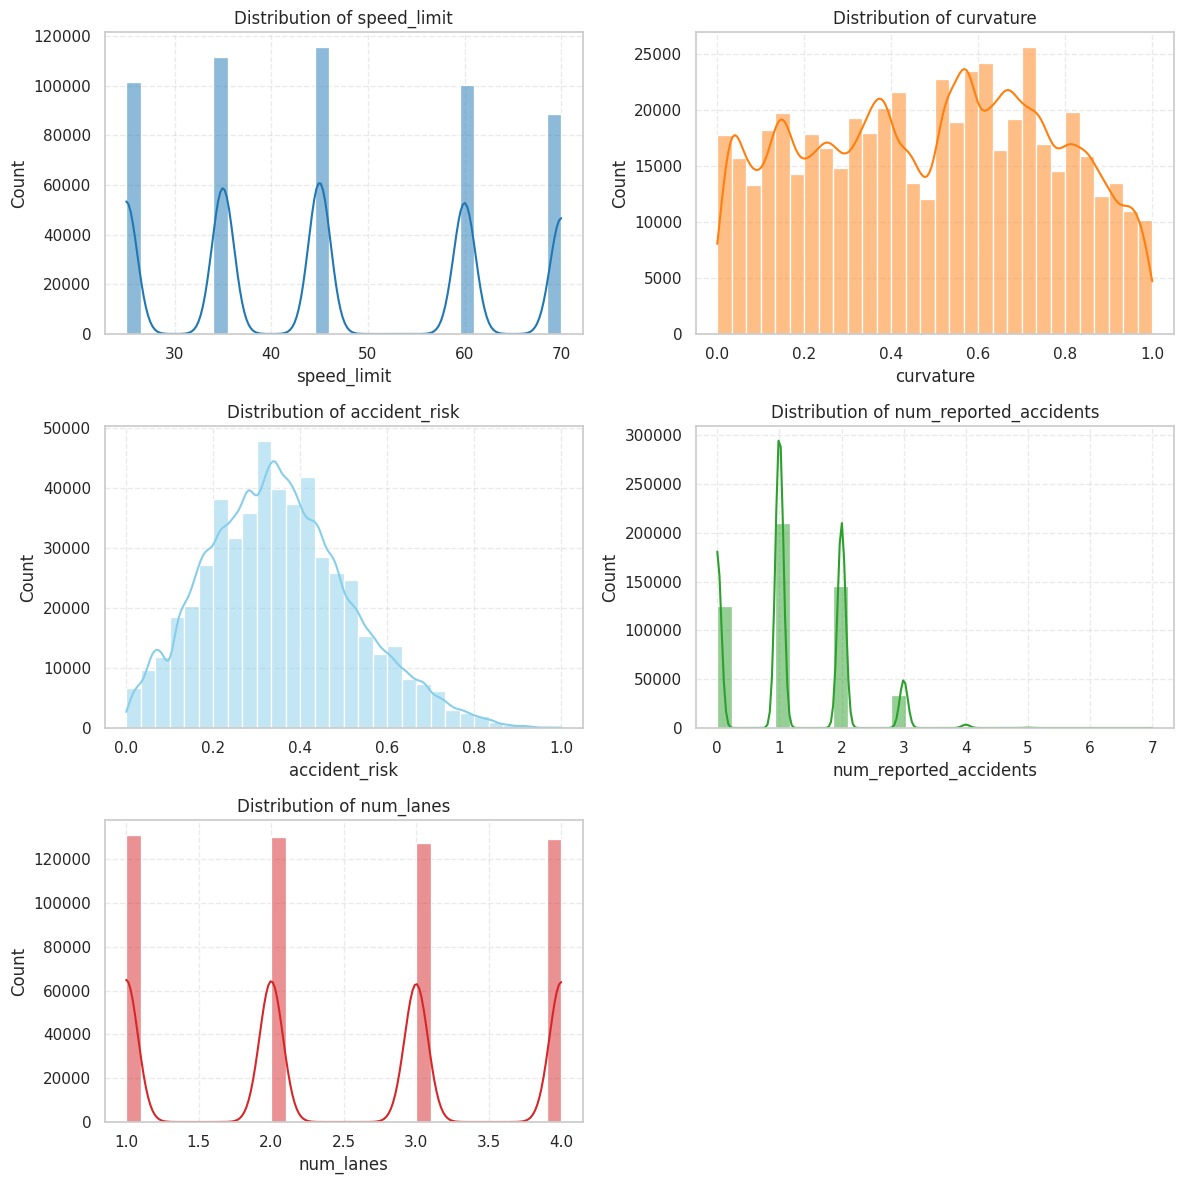

In [7]:
num_features = [
    'speed_limit', 'curvature', 'accident_risk',
    'num_reported_accidents', 'num_lanes'
]

colors = ['#1f77b4', '#ff7f0e', '#87ceeb', '#2ca02c', '#d62728']

fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

for i, col in enumerate(num_features):
    sns.histplot(train[col], bins=30, kde=True, color=colors[i], ax=axes[i])
    axes[i].set_title(f"Distribution of {col}", fontsize=12)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")
    axes[i].grid(True, linestyle='--', alpha=0.4)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.show()

### Boxplots of accident risk for discrete and binned continuous features

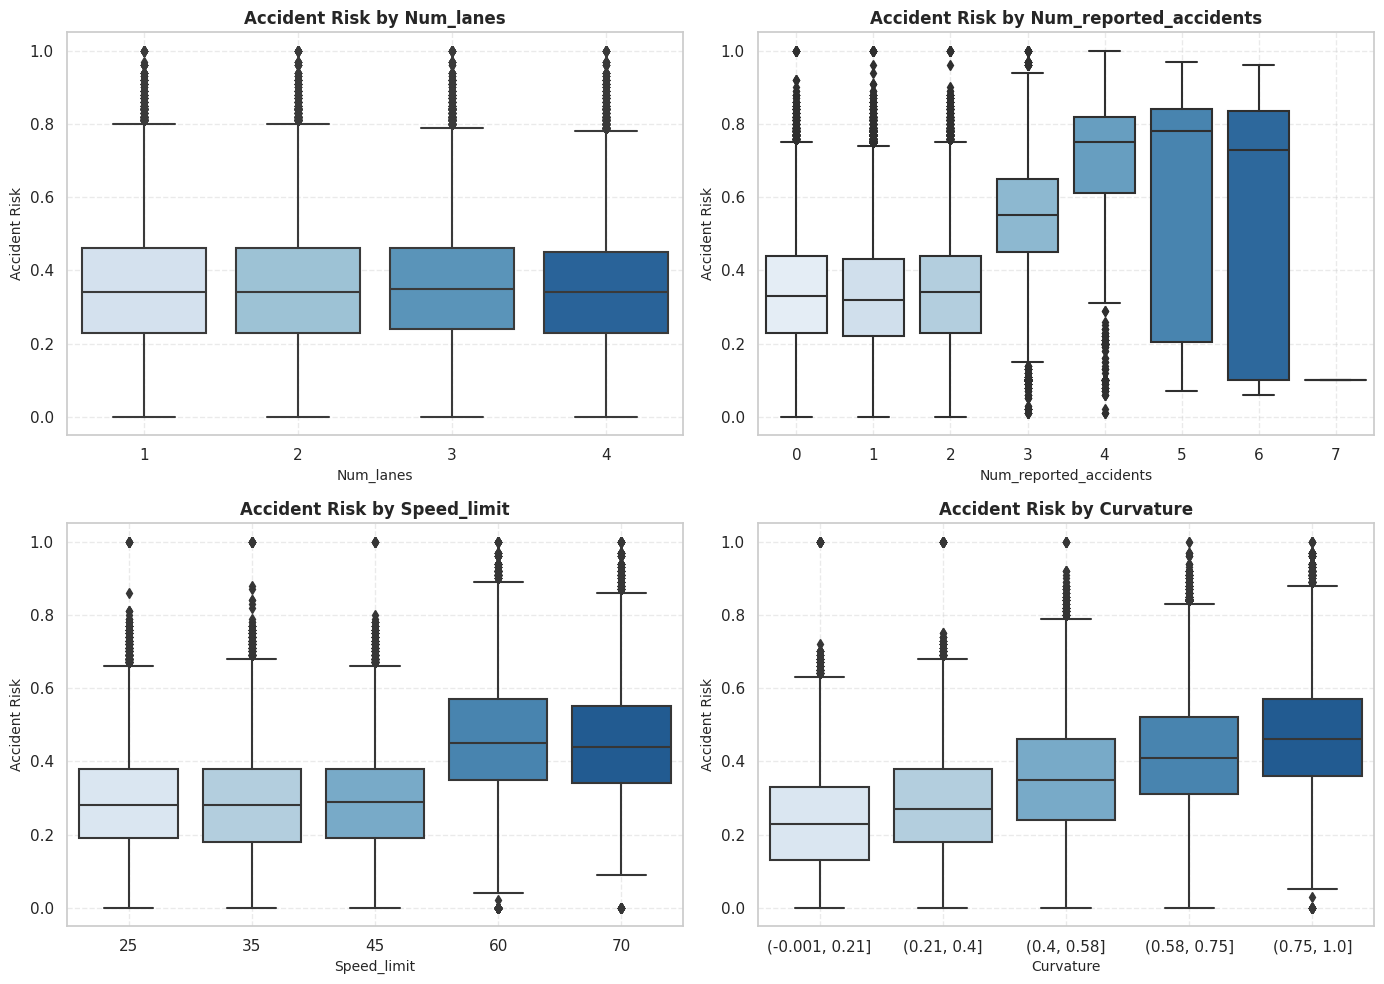

In [8]:
sns.set_theme(style="whitegrid")

discrete_features = ['num_lanes', 'num_reported_accidents', 'speed_limit']
continuous_features = ['curvature']
all_features = discrete_features + continuous_features

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for i, col in enumerate(all_features):
    if col in continuous_features:
        # Bin continuous feature into 5 quantiles
        train[f'{col}_bin'] = pd.qcut(train[col], q=5, duplicates='drop')
        x_col = f'{col}_bin'
    else:
        x_col = col  # Use discrete feature as is

    sns.boxplot(
        x=x_col,
        y='accident_risk',
        data=train,
        ax=axes[i],
        palette="Blues"
    )

    axes[i].set_title(f"Accident Risk by {col.capitalize()}", fontsize=12, weight='bold')
    axes[i].set_xlabel(col.capitalize(), fontsize=10)
    axes[i].set_ylabel("Accident Risk", fontsize=10)
    axes[i].tick_params(axis='x')
    axes[i].grid(True, linestyle='--', alpha=0.4)

for j in range(len(all_features), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## preprocessing and feature engineering

**Optimize feature weights for maximum accident risk correlation**

In [9]:
import numpy as np
from scipy.optimize import minimize

def neg_corr(weights, df):
    w_curv, w_light, w_weather, w_speed, w_acc = weights
    
    risk = (
        w_curv   * df['curvature'] +
        w_light  * (df['lighting'] == "night").astype(int) +  # lighting == "night"
        w_weather* (df["weather"] != "clear").astype(int) +     # weather != "clear"
        w_speed  * (df['speed_limit'] >= 60).astype(int) +
        w_acc    * (df['num_reported_accidents'] > 2).astype(int)
    )
    
    return -np.corrcoef(risk, df['accident_risk'])[0, 1]

bounds = [(0, 1)] * 5

np.random.seed(42)
random_start = np.random.rand(5)

result = minimize(
    neg_corr,
    random_start,
    args=(train,),
    bounds=bounds
)

best_weights = result.x

feature_names = ['curvature', 'lighting', 'weather', 'speed_limit', 'num_reported_accidents']
print("Coefficients optimaux :")
for name, w in zip(feature_names, best_weights):
    print(f"{name}: {w:.3f}")

final_corr = -neg_corr(best_weights, train)
print(f"\nCorrelation : {final_corr:.3f}")

Coefficients optimaux :
curvature: 0.999
lighting: 0.622
weather: 0.305
speed_limit: 0.611
num_reported_accidents: 0.317

Correlation : 0.937


**normalize weights**

In [10]:
best_weights = np.array([0.999, 0.622, 0.305, 0.611, 0.317])
normalized_weights = np.round(best_weights / 3, 1)

for name, w in zip(['curvature','lighting','weather','speed_limit','num_reported_accidents'], normalized_weights):
    print(f"{name}: {w}")

curvature: 0.3
lighting: 0.2
weather: 0.1
speed_limit: 0.2
num_reported_accidents: 0.1


**Base Risk Feature**

In [11]:
def compute_base_risk(df):
    return (
        0.3 * df["curvature"] +
        0.2 * (df["lighting"] == "night").astype(int) +
        0.1 * (df["weather"] != "clear").astype(int) +
        0.2 * (df["speed_limit"] >= 60).astype(int) +
        0.1 * (np.array(df["num_reported_accidents"]) > 2).astype(int)
    )

train["base_risk"] = compute_base_risk(train)
test["base_risk"] = compute_base_risk(test)

**Feature Encoding**

In [12]:
categorical_cols = ['weather','road_type','time_of_day']
train = pd.get_dummies(train, columns=categorical_cols, drop_first=False)
test = pd.get_dummies(test, columns=categorical_cols, drop_first=False)

lighting_mapping = {'daylight': 0, 'dim': 0, 'night': 1}
train['lighting_encoded'] = train['lighting'].map(lighting_mapping)
test['lighting_encoded'] = test['lighting'].map(lighting_mapping)

binary_cols = ['holiday','school_season','road_signs_present','public_road']
for col in binary_cols:
    train[col] = train[col].astype(int)
    test[col] = test[col].astype(int)

**Remove ID Column**

In [13]:
test_ids = test['id']

train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

**Boxplots of accident risk vs engineered features**

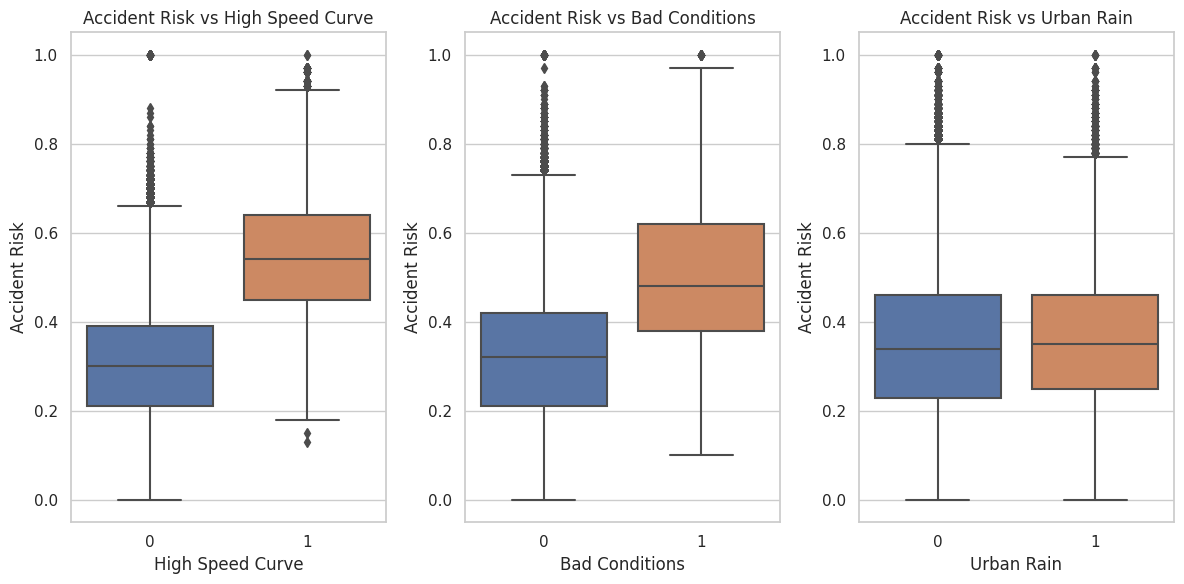

In [14]:
binary_features = {
    'High Speed Curve': (train['speed_limit'] >= 60) & (train['curvature'] > 0.5),
    'Bad Conditions': ((train.get('weather_rainy',0) == 1) | (train.get('weather_foggy',0) == 1)) & (train['lighting_encoded'] == 1),
    'Urban Rain': (train.filter(like='road_type_urban').max(axis=1) == 1) & (train.get('weather_rainy',0) == 1),
}

plt.figure(figsize=(12,6))

for i, (name, feature) in enumerate(binary_features.items(), 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x=feature.astype(int), y=train['accident_risk'])
    plt.title(f"Accident Risk vs {name}")
    plt.xlabel(name)
    plt.ylabel("Accident Risk")

plt.tight_layout()
plt.show()

**Scatter plots of accident risk vs combined features**

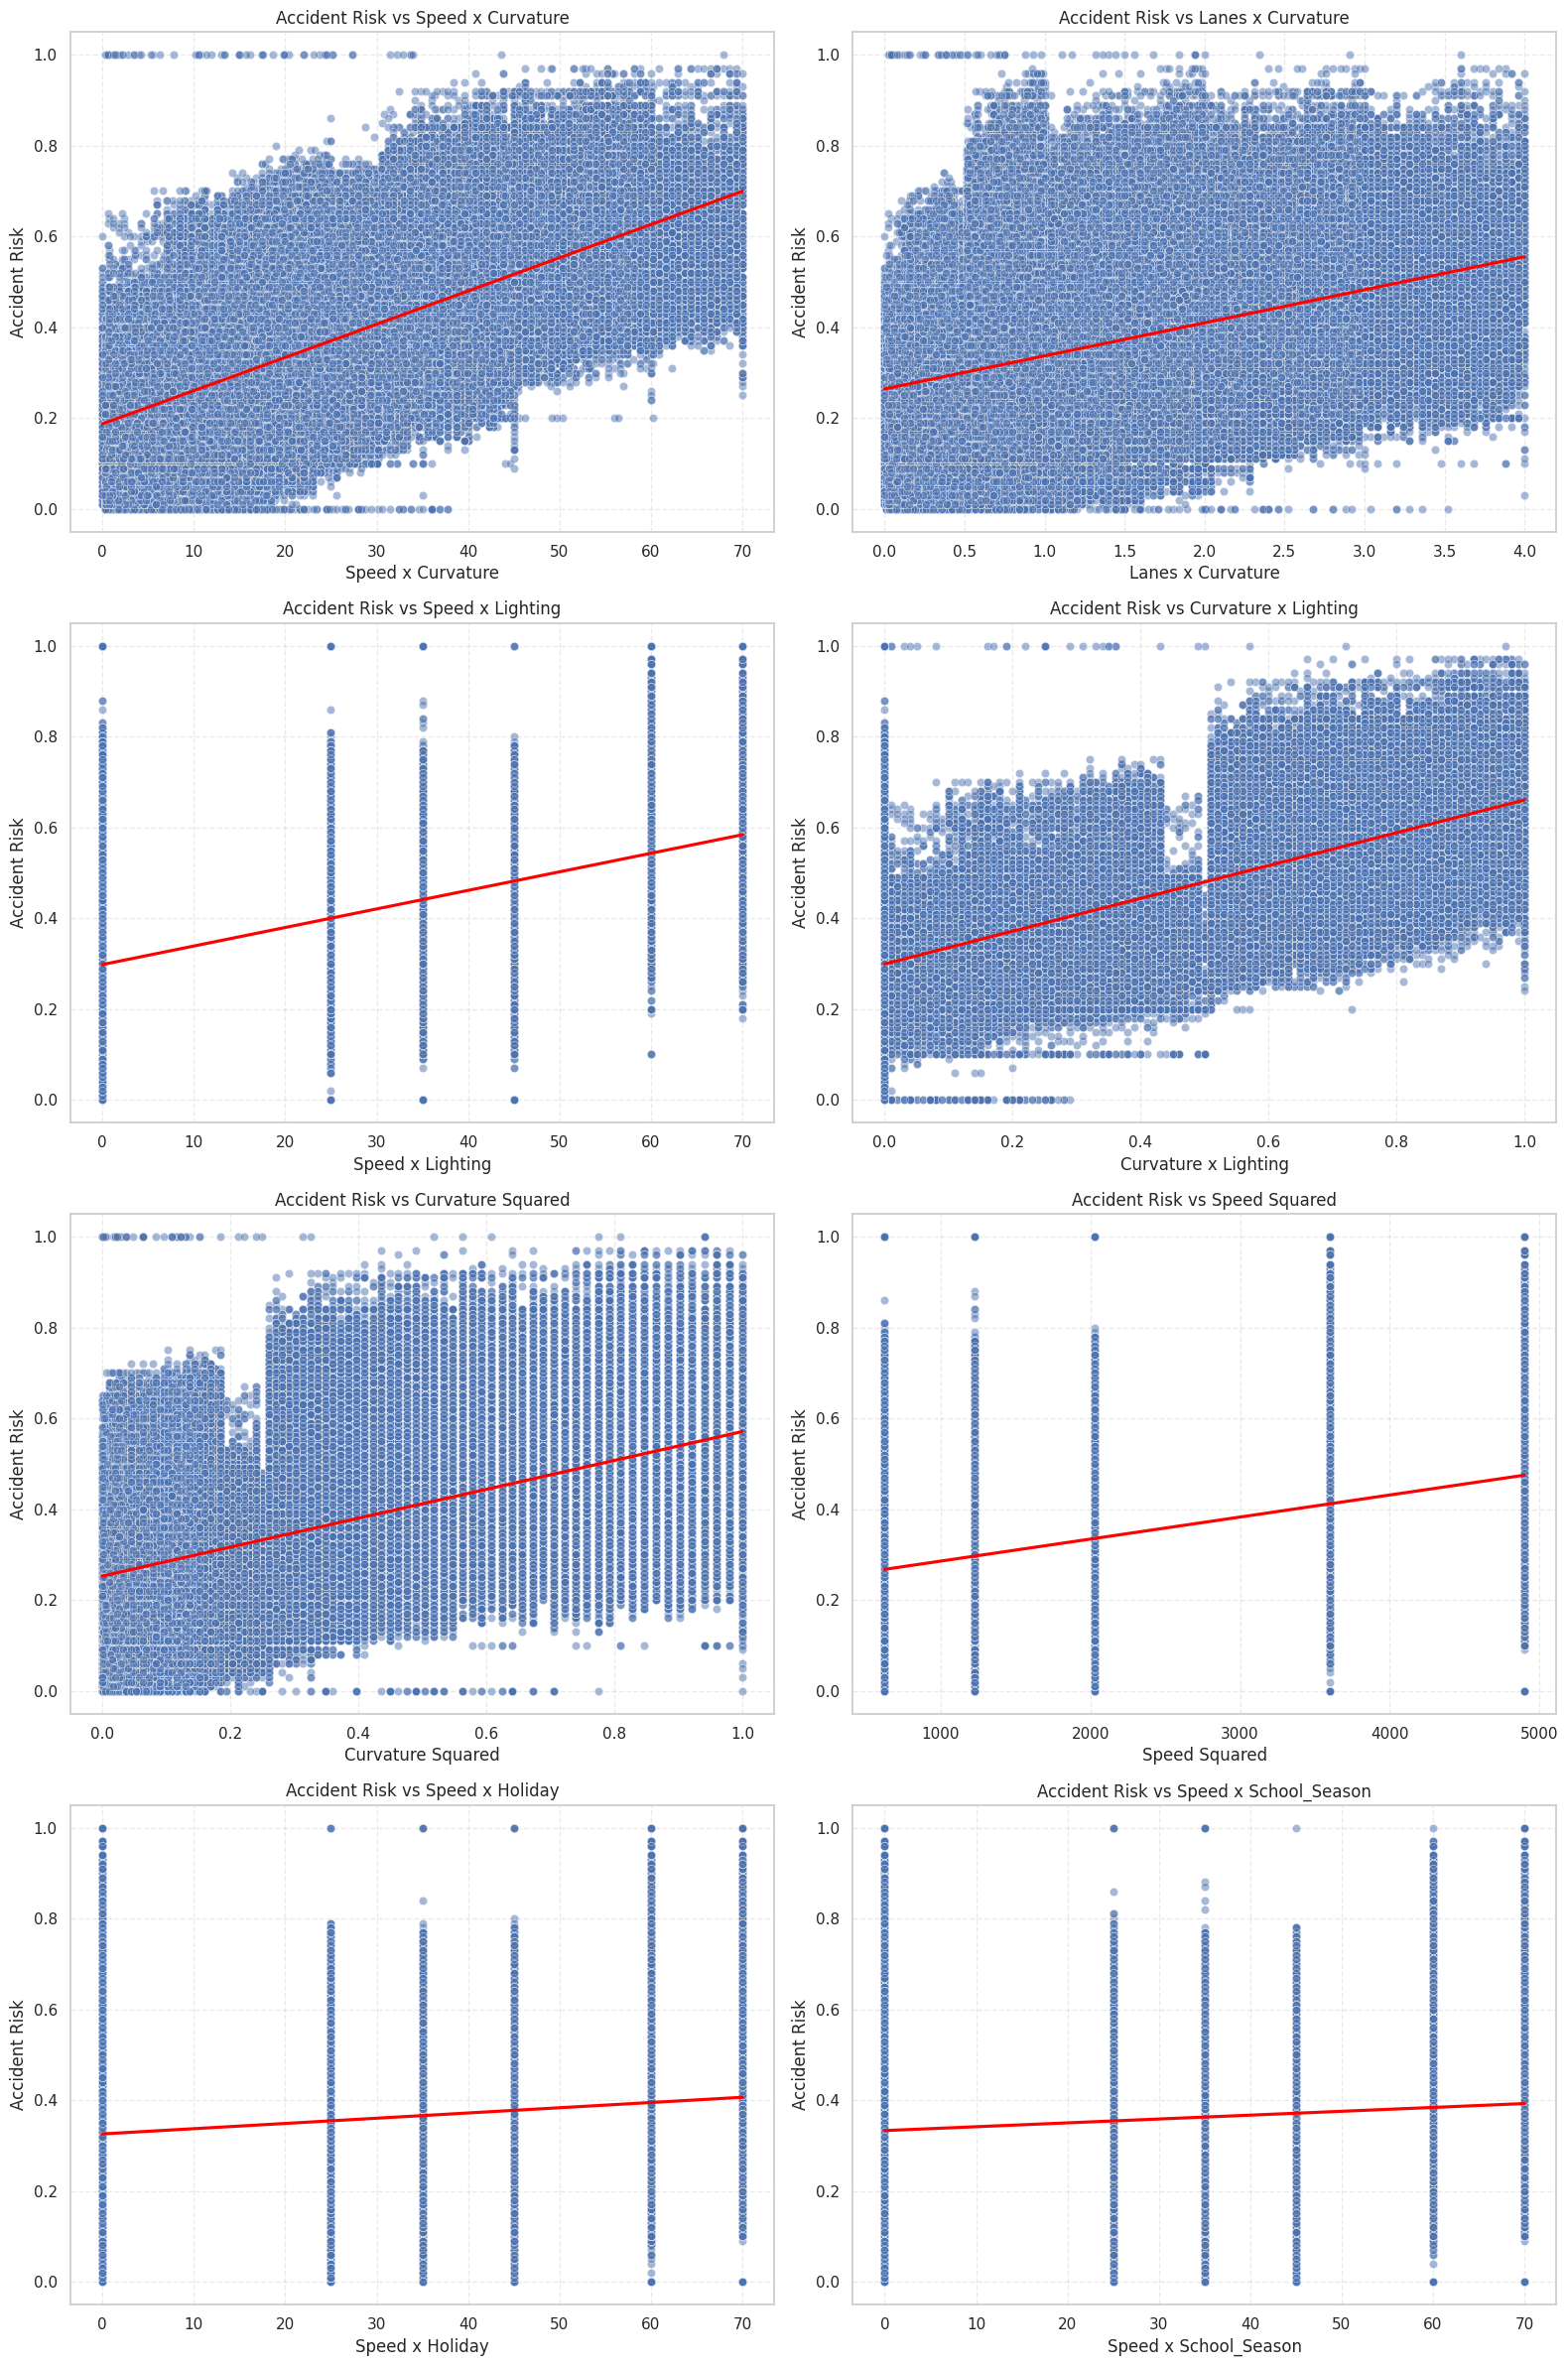

In [15]:
import math

combined_features = {
    'Speed x Curvature': train['speed_limit'] * train['curvature'],
    'Lanes x Curvature': train['num_lanes'] * train['curvature'],
    'Speed x Lighting': train['speed_limit'] * train['lighting_encoded'],
    'Curvature x Lighting': train['curvature'] * train['lighting_encoded'],
    'Curvature Squared': train['curvature'] ** 2,
    'Speed Squared': train['speed_limit'] ** 2,
    'Speed x Holiday': train['speed_limit'] * train['holiday'],
    'Speed x School_Season': train['speed_limit'] * train['school_season'],

}

features = combined_features
n_features = len(features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

plt.figure(figsize=(16, 6*n_rows))

for i, (name, feature) in enumerate(features.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    sns.scatterplot(x=feature, y=train['accident_risk'], alpha=0.5)
    sns.regplot(x=feature, y=train['accident_risk'], scatter=False, color='red')
    plt.title(f"Accident Risk vs {name}")
    plt.xlabel(name)
    plt.ylabel("Accident Risk")
    plt.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

**Create interaction & derived features based on plots analysis**

In [16]:
for df in [train, test]:
    df['speed_curvature'] = df['speed_limit'] * df['curvature']
    df['lanes_curvature'] = df['num_lanes'] * df['curvature']
    df['speed_lighting'] = df['speed_limit'] * df['lighting_encoded']
    df['curvature_lighting'] = df['curvature'] * df['lighting_encoded']
    df['high_speed_curve'] = ((df['speed_limit'] >= 60) & (df['curvature'] > 0.5)).astype(int)
    df['curvature_squared'] = df['curvature'] ** 2
    df['speed_squared'] = df['speed_limit'] ** 2
    df['bad_conditions'] = (((df.get('weather_rainy',0) == 1) | (df.get('weather_foggy',0) == 1)) & (df['lighting_encoded'] == 1)).astype(int)
   
for col in train.columns:
    if col not in test.columns and col != 'accident_risk':
        test[col] = 0

**check and remove duplicates**

In [17]:
num_duplicates = train.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)

Number of duplicate rows: 656


In [18]:
train = train.drop_duplicates()